# Cycle Time 예측

## 라이브러리 import

In [148]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import os, random, time, gc, warnings

from tqdm import tqdm_notebook

import lightgbm as lgbm
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import RFECV


from sklearn.cluster import KMeans

from datetime import datetime

from math import sqrt
import io

warnings.filterwarnings('ignore')

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

%matplotlib inline

## 데이터 전처리

### 데이터 확인

In [149]:
from google.colab import files
file_uploaded = files.upload()

KeyboardInterrupt: ignored

In [ ]:
df=pd.read_csv(io.BytesIO(file_uploaded['data-04.02-초로환산.csv']))
print(df.shape)
df.head()

### 이상치 제거

In [ ]:
# 시간이 하나도 찍히지 않은 제품 식별 후 삭제
df_idx_1 = df[(df['m1in'] == '0:00:00') & (df['m1out'] == '0:00:00') & (df['m2in'] == '0:00:00') & (df['m2out'] == '0:00:00') & (df['m3in'] == '0:00:00') & (df['m3out'] == '0:00:00')].index
# len(df_idx)
df_sample_1 = df.drop(df_idx_1)
len(df_sample_1)

In [ ]:
df_sample_1.describe()

In [ ]:
df_sample_1.info()

In [ ]:
drop_column=['m1in', 'm1process', 'm1out', 'm2in', 'm2process', 'm2out', 'm3in' ,'m3process', 'm3out', 'Unnamed: 13',
             'Unnamed: 15', 'Unnamed: 18', 'Unnamed: 21', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25'
             ,'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31'
             ,'Unnamed: 32', 'Unnamed: 33', 'uid', 'completed', 'cycle'] 
df_dropped=df_sample_1.drop(drop_column, axis=1, inplace=False)

In [ ]:
df_dropped.info()

In [ ]:
df_dropped.describe()

In [ ]:
#인덱스 설정
df_dropped_setIdx=df_dropped.set_index('index')
df_dropped_setIdx.head()
#인덱스 리셋
df_dropped_resetIdx = df_dropped_setIdx.reset_index(drop=True)
df_dropped_resetIdx.head(10)

In [ ]:
# 행을 돌면서 m1in<m1out<m2in<m2out<m3in<m3out 구조를 따르지 않는 데이터 값 삭제
for i, j in enumerate(df_dropped_resetIdx['m1iN']):
    # 왼쪽을 살리고 오른쪽값 0으로 변환
    # m1in, m1out 비교
    if df_dropped_resetIdx.iloc[i, 1] < df_dropped_resetIdx.iloc[i, 0]:
        df_dropped_resetIdx.iloc[i, 1] = 0
    # m1out, m2in 비교
    if df_dropped_resetIdx.iloc[i, 2] < df_dropped_resetIdx.iloc[i, 1]:
        df_dropped_resetIdx.iloc[i, 2] = 0
    # m2in, m2out 비교
    if df_dropped_resetIdx.iloc[i, 3] < df_dropped_resetIdx.iloc[i, 2]:
        df_dropped_resetIdx.iloc[i, 3] = 0
    # m2out, m3in 비교
    if df_dropped_resetIdx.iloc[i, 4] < df_dropped_resetIdx.iloc[i, 3]:
        df_dropped_resetIdx.iloc[i, 4] = 0
    # m3in, m3out 비교
    if df_dropped_resetIdx.iloc[i, 5] < df_dropped_resetIdx.iloc[i, 4]:
        df_dropped_resetIdx.iloc[i, 5] = 0
df_dropped_resetIdx.head(10)

In [ ]:
# m1iN열을 기준으로 오름차순 정렬
df_dropped_resetIdx.sort_values(by=['m1iN'], axis=0, ascending=True)

In [ ]:
# m1in & m1out 둘 다 찍힌 인덱스
df_idx_1 = df_dropped_resetIdx[(df_dropped_resetIdx['m1iN'] != 0 ) & (df_dropped_resetIdx['m1ouT'] != 0 )].index
# m1out & m2in 둘 다 찍힌 인덱스
df_idx_2 = df_dropped_resetIdx[(df_dropped_resetIdx['m1ouT'] != 0 ) & (df_dropped_resetIdx['m2iN'] != 0 )].index
# m2in & m2out 둘 다 찍힌 인덱스
df_idx_3 = df_dropped_resetIdx[(df_dropped_resetIdx['m2iN'] != 0 ) & (df_dropped_resetIdx['m2ouT'] != 0 )].index
# m2out & m3in 둘 다 찍힌 인덱스
df_idx_4 = df_dropped_resetIdx[(df_dropped_resetIdx['m2ouT'] != 0 ) & (df_dropped_resetIdx['m3iN'] != 0 )].index
# m3in & m3out 둘 다 찍힌 인덱스
df_idx_5 = df_dropped_resetIdx[(df_dropped_resetIdx['m3iN'] != 0 ) & (df_dropped_resetIdx['m3ouT'] != 0 )].index

print(len(df_idx_1),len(df_idx_2),len(df_idx_3),len(df_idx_4),len(df_idx_5))

In [ ]:
# m1in ~ m1out 시간 차이 구하기
df_sample_2 = df_dropped_resetIdx.loc[df_idx_1]
df_sample_2['difference_1'] = df_sample_2['m1ouT'] - df_sample_2['m1iN']
# m1out ~ m2in 시간 차이 구하기
df_sample_3 = df_dropped_resetIdx.loc[df_idx_2]
df_sample_3['difference_2'] = df_sample_3['m2iN'] - df_sample_3['m1ouT']
# m2in ~ m2out 시간 차이 구하기
df_sample_4 = df_dropped_resetIdx.loc[df_idx_3]
df_sample_4['difference_3'] = df_sample_4['m2ouT'] - df_sample_4['m2iN']
# m2out ~ m3in 시간 차이 구하기
df_sample_5 = df_dropped_resetIdx.loc[df_idx_4]
df_sample_5['difference_4'] = df_sample_5['m3iN'] - df_sample_5['m2ouT']
# m3in ~ m3out 시간 차이 구하기
df_sample_6 = df_dropped_resetIdx.loc[df_idx_5]
df_sample_6['difference_5'] = df_sample_6['m3ouT'] - df_sample_6['m3iN']

print(df_sample_2['difference_1'].mean(),'---', df_sample_3['difference_2'].mean(),'---', df_sample_4['difference_3'].mean()
     ,'---',df_sample_5['difference_4'].mean(),'---', df_sample_6['difference_5'].mean())

In [ ]:
df_sample_2['difference_1'].hist()

In [ ]:
df_sample_3['difference_2'].hist()

In [ ]:
df_sample_4['difference_3'].hist()

In [ ]:
df_sample_5['difference_4'].hist()

In [ ]:
df_sample_6['difference_5'].hist()

In [ ]:
# m1in ~ m1out 시간 차이 중에서 너무 큰 값은 이상치로 판단 -> 제거
for i, j in enumerate(df_dropped_resetIdx['m1iN']):
    # m1in, m1out 비교
    if (df_dropped_resetIdx.iloc[i, 1] - df_dropped_resetIdx.iloc[i, 0])>600:
        df_dropped_resetIdx.iloc[i, 1] = 0
        
# m1in & m1out 둘 다 찍힌 인덱스
df_idx_1 = df_dropped_resetIdx[(df_dropped_resetIdx['m1iN'] != 0 ) & (df_dropped_resetIdx['m1ouT'] != 0 )].index

# m1in ~ m1out 시간 차이 구하기
df_sample_2 = df_dropped_resetIdx.loc[df_idx_1]
df_sample_2['difference_1'] = df_sample_2['m1ouT'] - df_sample_2['m1iN']

df_sample_2['difference_1'].hist()

### 결측치 대체

In [ ]:
print(df_sample_2['difference_1'].describe(),'\n', df_sample_3['difference_2'].describe(),'\n'
     ,df_sample_4['difference_3'].describe(),'\n',df_sample_5['difference_4'].describe(),'\n'
     ,df_sample_6['difference_5'].describe())

In [ ]:
rand_norm2

In [ ]:
# 행을 돌면서 결측치를 평균 값으로 대체

# 난수 생성
mu1, sigma1 = df_sample_2['difference_1'].mean(), (df_sample_2['difference_1'].std())/10
rand_norm1 = np.random.normal(mu1, sigma1, size=500)

mu2, sigma2 = df_sample_3['difference_2'].mean(), (df_sample_3['difference_2'].std())/10
rand_norm2 = np.random.normal(mu2, sigma2, size=500)

mu3, sigma3 = df_sample_4['difference_3'].mean(), (df_sample_4['difference_3'].std())/10
rand_norm3 = np.random.normal(mu3, sigma3, size=500)

mu4, sigma4 = df_sample_5['difference_4'].mean(), (df_sample_5['difference_4'].std())/10
rand_norm4 = np.random.normal(mu4, sigma4, size=500)

mu5, sigma5 = df_sample_6['difference_5'].mean(), (df_sample_6['difference_5'].std())/10
rand_norm5 = np.random.normal(mu5, sigma5, size=500)



for i, j in enumerate(df_dropped_resetIdx['m1iN']):
    # m1in이 0이고 m1out이 0이 아니면 차이의 평균으로 값 대체
    if df_dropped_resetIdx.iloc[i, 0] == 0:
        if df_dropped_resetIdx.iloc[i, 1] != 0:
            #rand_norm1 = np.random.normal(mu1, sigma1, size=1)
            df_dropped_resetIdx.iloc[i, 0] = df_dropped_resetIdx.iloc[i, 1] - round(rand_norm1[i])
    # m1out이 0이고 m2in이 0이 아니면 차이의 평균으로 값 대체
    if df_dropped_resetIdx.iloc[i, 1] == 0:
        if df_dropped_resetIdx.iloc[i, 2] != 0:
            #rand_norm2 = np.random.normal(mu2, sigma2, size=1)
            df_dropped_resetIdx.iloc[i, 1] = df_dropped_resetIdx.iloc[i, 2] - round(rand_norm2[i])
    # m2in이 0이고 m2out이 0이 아니면 차이의 평균으로 값 대체
    if df_dropped_resetIdx.iloc[i, 2] == 0:
        if df_dropped_resetIdx.iloc[i, 3] != 0:
            #rand_norm3 = np.random.normal(mu3, sigma3, size=1)
            df_dropped_resetIdx.iloc[i, 2] = df_dropped_resetIdx.iloc[i, 3] - round(rand_norm3[i])
    # m2out이 0이고 m3in이 0이 아니면 차이의 평균으로 값 대체
    if df_dropped_resetIdx.iloc[i, 3] == 0:
        if df_dropped_resetIdx.iloc[i, 4] != 0:
            #rand_norm4 = np.random.normal(mu4, sigma4, size=1)
            df_dropped_resetIdx.iloc[i, 3] = df_dropped_resetIdx.iloc[i, 4] - round(rand_norm4[i])
    # m3in이 0이고 m3out이 0이 아니면 차이의 평균으로 값 대체
    if df_dropped_resetIdx.iloc[i, 4] == 0:
        if df_dropped_resetIdx.iloc[i, 5] != 0:
            #rand_norm5 = np.random.normal(mu5, sigma5, size=1)
            df_dropped_resetIdx.iloc[i, 4] = df_dropped_resetIdx.iloc[i, 5] - round(rand_norm5[i])

# 4번정도 돌리는게 적당 그 후로는 값이 안바뀜            
df_dropped_resetIdx

In [155]:
# 행을 돌면서 결측치를 평균 값으로 대체 -> 역순으로 실행
for i, j in enumerate(df_dropped_resetIdx['m1iN']):
    # m1in이 0이고 m1out이 0이 아니면 차이의 평균으로 값 대체
    if df_dropped_resetIdx.iloc[i, 5] == 0:
        if df_dropped_resetIdx.iloc[i, 4] != 0:
            df_dropped_resetIdx.iloc[i, 5] = df_dropped_resetIdx.iloc[i, 4] + round(rand_norm5[i+200])
    # m1out이 0이고 m2in이 0이 아니면 차이의 평균으로 값 대체
    if df_dropped_resetIdx.iloc[i, 4] == 0:
        if df_dropped_resetIdx.iloc[i, 3] != 0:
            df_dropped_resetIdx.iloc[i, 4] = df_dropped_resetIdx.iloc[i, 3] + round(rand_norm4[i+200])
    # m1in이 0이고 m1out이 0이 아니면 차이의 평균으로 값 대체
    if df_dropped_resetIdx.iloc[i, 3] == 0:
        if df_dropped_resetIdx.iloc[i, 2] != 0:
            df_dropped_resetIdx.iloc[i, 3] = df_dropped_resetIdx.iloc[i, 2] + round(rand_norm3[i+200])
    # m1in이 0이고 m1out이 0이 아니면 차이의 평균으로 값 대체
    if df_dropped_resetIdx.iloc[i, 2] == 0:
        if df_dropped_resetIdx.iloc[i, 1] != 0:
            df_dropped_resetIdx.iloc[i, 2] = df_dropped_resetIdx.iloc[i, 1] + round(rand_norm2[i+200])
    # m1in이 0이고 m1out이 0이 아니면 차이의 평균으로 값 대체
    if df_dropped_resetIdx.iloc[i, 1] == 0:
        if df_dropped_resetIdx.iloc[i, 0] != 0:
            df_dropped_resetIdx.iloc[i, 1] = df_dropped_resetIdx.iloc[i, 0] + round(rand_norm1[i+200])

# 4번정도 돌리는게 적당 그 후로는 값이 안바뀜            
df_dropped_resetIdx
df_completed = df_dropped_resetIdx.sort_values(by=['m1iN'], axis=0, ascending=True)
df_completed.to_pickle("df_completed.pkl")
df_completed.to_csv("df_completed.csv")
df_completed

,m1iN,m1ouT,m2iN,m2ouT,m3iN,m3ouT
10,58363,58534,58561,58576,58589,58595
24,58379,58555,58593,58652,58666,58667
107,58435,58592,58611,58679,58691,58694
57,58466,58631,58656,58721,58741,58766
86,58545,58557,58514,58568,58582,58586
36,58560,58564,58566,58590,58602,58604
12,58569,58729,58757,58813,58825,58877
29,58580,58591,58560,58628,58646,58650
93,58588,58597,58600,58810,58823,58873
87,58612,58615,58618,58688,58698,58706


### 데이터 가공

In [ ]:
# df_completed 사용, step: 100
totalTime = []
for i in range(int(min(df_completed['m1iN'])),int(max(df_completed['m3ouT']))+1,25): #m1in min 시간과 m3out max 시간
    totalTime.append(i)
len(totalTime), len(df_completed)

In [ ]:
# 데이터 받고 돌려볼 로직
#12시31분 -> 12시50분
#timeData = 51534
#m1_buffer , m1m2, m2buffer, m2m3, m3buffer = 0, 0, 0, 0, 0

list2=[]

m1_buffer_list =[]
m1m2_list =[]
m2buffer_list =[]
m2m3_list =[]
m3buffer_list =[]
#ct_list=[]

for timeData in totalTime:
    m1_buffer , m1m2, m2buffer, m2m3, m3buffer = 0, 0, 0, 0, 0
    ct_idx=0
    #ct=0
    print('--------------------------------------------------------',timeData)
    for i, j in enumerate(df_completed['m1iN']):
        if (timeData >= df_completed.loc[[i],['m1iN']]).bool() & (timeData <= df_completed.loc[[i],['m1ouT']]).bool():
            m1_buffer +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['m1ouT']]).bool() & (timeData <= df_completed.loc[[i],['m2iN']]).bool():
            m1m2 +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['m2iN']]).bool() & (timeData <= df_completed.loc[[i],['m2ouT']]).bool():
            m2buffer +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['m2ouT']]).bool() & (timeData <= df_completed.loc[[i],['m3iN']]).bool():
            m2m3 +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['m3iN']]).bool() & (timeData <= df_completed.loc[[i],['m3ouT']]).bool():
            m3buffer +=1
            ct_idx=i
    
    #ct = df_completed.loc[[ct_idx],['m3ouT']] - df_completed.loc[[ct_idx],['m1iN']]
    #ct = df_completed.iloc[ct_idx+1, 5] - df_completed.iloc[ct_idx+1, 0] #자리위치로 연산

    m1_buffer_list.append(m1_buffer)
    m1m2_list.append(m1m2)
    m2buffer_list.append(m2buffer)
    m2m3_list.append(m2m3)
    m3buffer_list.append(m3buffer)
    #ct_list.append(ct)
    
df_3 = pd.DataFrame({'m1_buffer':m1_buffer_list,
                     'm1m2':m1m2_list,
                     'm2buffer':m2buffer_list,
                     'm2m3':m2m3_list,
                     'm3buffer':m3buffer_list,
                     #'CycleTime':ct_list
                      })

In [154]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [153]:
df_3['CycleTime'] = df_completed['m3ouT'] - df_completed['m1iN']
#print(df_completed['m3ouT'][63], df_completed['m1iN'][63])
df_3
df_3.to_pickle("df_3.pkl")
df_3.to_csv("df_3.csv")

In [150]:
# cycletime 음수 행 삭제
df_4 = df_3.drop([63])
# 불완전 데이터 삭제, 처음, 끝
df_5 = df_4.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,109,110,111,112,113,114,115])
df_5

,m1_buffer,m1m2,m2buffer,m2m3,m3buffer,CycleTime
15,6,1,3,2,1,187.0
16,7,1,4,0,2,763.0
17,10,0,3,1,1,325.0
18,11,0,2,1,1,298.0
19,11,1,2,0,2,498.0
20,11,1,1,1,3,193.0
21,12,1,0,0,3,217.0
22,11,1,0,0,3,315.0
23,10,3,0,0,2,305.0
24,11,2,1,0,1,288.0


In [ ]:
# df_completed 사용, step: 10
'''
totalTime = []
for i in range(int(min(df_completed['m1iN'])),int(max(df_completed['m3ouT']))+1,10): #m1in min 시간과 m3out max 시간
    totalTime.append(i)
len(totalTime)
'''

In [ ]:
# 데이터 받고 돌려볼 로직
#12시31분 -> 12시50분
#timeData = 51534
#m1_buffer , m1m2, m2buffer, m2m3, m3buffer = 0, 0, 0, 0, 0
'''
list2=[]

m1_buffer_list =[]
m1m2_list =[]
m2buffer_list =[]
m2m3_list =[]
m3buffer_list =[]
#ct_list=[]

for timeData in totalTime:
    m1_buffer , m1m2, m2buffer, m2m3, m3buffer = 0, 0, 0, 0, 0
    ct_idx=0
    #ct=0
    for i, j in enumerate(df_completed['m1iN']):
        if (timeData >= df_completed.loc[[i],['m1iN']]).bool() & (timeData <= df_completed.loc[[i],['m1ouT']]).bool():
            m1_buffer +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['m1ouT']]).bool() & (timeData <= df_completed.loc[[i],['m2iN']]).bool():
            m1m2 +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['m2iN']]).bool() & (timeData <= df_completed.loc[[i],['m2ouT']]).bool():
            m2buffer +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['m2ouT']]).bool() & (timeData <= df_completed.loc[[i],['m3iN']]).bool():
            m2m3 +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['m3iN']]).bool() & (timeData <= df_completed.loc[[i],['m3ouT']]).bool():
            m3buffer +=1
            ct_idx=i
    
    #ct = df_completed.loc[[ct_idx],['m3ouT']] - df_completed.loc[[ct_idx],['m1iN']]
    #ct = df_completed.iloc[ct_idx+1, 5] - df_completed.iloc[ct_idx+1, 0] #자리위치로 연산

    m1_buffer_list.append(m1_buffer)
    m1m2_list.append(m1m2)
    m2buffer_list.append(m2buffer)
    m2m3_list.append(m2m3)
    m3buffer_list.append(m3buffer)
    #ct_list.append(ct)
    
df_4 = pd.DataFrame({'m1_buffer':m1_buffer_list,
                     'm1m2':m1m2_list,
                     'm2buffer':m2buffer_list,
                     'm2m3':m2m3_list,
                     'm3buffer':m3buffer_list,
                     #'CycleTime':ct_list
                      })
'''

In [ ]:
#df_4

In [ ]:
#df_4['CycleTime'] = df_completed['m3ouT'] - df_completed['m1iN']
#df_4

In [ ]:
# df_completed 사용, step: 1
'''
totalTime = []
for i in range(int(min(df_completed['m1iN'])),int(max(df_completed['m3ouT']))+1): #m1in min 시간과 m3out max 시간
    totalTime.append(i)
len(totalTime)
'''

In [ ]:
# 데이터 받고 돌려볼 로직
#12시31분 -> 12시50분
#timeData = 51534
#m1_buffer , m1m2, m2buffer, m2m3, m3buffer = 0, 0, 0, 0, 0
'''
list2=[]

m1_buffer_list =[]
m1m2_list =[]
m2buffer_list =[]
m2m3_list =[]
m3buffer_list =[]
#ct_list=[]

for timeData in totalTime:
    m1_buffer , m1m2, m2buffer, m2m3, m3buffer = 0, 0, 0, 0, 0
    ct_idx=0
    #ct=0
    for i, j in enumerate(df_completed['m1iN']):
        if (timeData >= df_completed.loc[[i],['m1iN']]).bool() & (timeData <= df_completed.loc[[i],['m1ouT']]).bool():
            m1_buffer +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['m1ouT']]).bool() & (timeData <= df_completed.loc[[i],['m2iN']]).bool():
            m1m2 +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['m2iN']]).bool() & (timeData <= df_completed.loc[[i],['m2ouT']]).bool():
            m2buffer +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['m2ouT']]).bool() & (timeData <= df_completed.loc[[i],['m3iN']]).bool():
            m2m3 +=1
            ct_idx=i
        elif (timeData >= df_completed.loc[[i],['m3iN']]).bool() & (timeData <= df_completed.loc[[i],['m3ouT']]).bool():
            m3buffer +=1
            ct_idx=i
    
    #ct = df_completed.loc[[ct_idx],['m3ouT']] - df_completed.loc[[ct_idx],['m1iN']]
    #ct = df_completed.iloc[ct_idx+1, 5] - df_completed.iloc[ct_idx+1, 0] #자리위치로 연산

    m1_buffer_list.append(m1_buffer)
    m1m2_list.append(m1m2)
    m2buffer_list.append(m2buffer)
    m2m3_list.append(m2m3)
    m3buffer_list.append(m3buffer)
    #ct_list.append(ct)
    
df_5 = pd.DataFrame({'m1_buffer':m1_buffer_list,
                     'm1m2':m1m2_list,
                     'm2buffer':m2buffer_list,
                     'm2m3':m2m3_list,
                     'm3buffer':m3buffer_list,
                     #'CycleTime':ct_list
                      })
'''

In [ ]:
#df_5['CycleTime'] = df_completed['m3ouT'] - df_completed['m1iN']
#df_5

# Modeling

## BaseLine_LinearRegression

In [147]:
df_5['CycleTime'].describe()

count     93.000000
mean     342.268817
std      191.669787
min       37.000000
25%      231.000000
50%      293.000000
75%      417.000000
max      904.000000
Name: CycleTime, dtype: float64

In [108]:
# 평가함수 정의
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def rmsle(y, pred):
    log_y=np.log1p(y)
    log_pred=np.log1p(pred)
    squared_error=(log_y - log_pred)**2
    rmsle=np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.10f}, RMSE: {1:.10f}, MAE: {2:.10f}'.format(rmsle_val, rmse_val, mae_val))

In [112]:
# 데이터 분할
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = df_5['CycleTime']
X_features = df_5.drop(['CycleTime'],axis=1,inplace=False)

X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
pred=lr_reg.predict(X_test)

evaluate_regr(y_test,pred)
len(pred)

RMSLE: 0.5044173227, RMSE: 167.1459818147, MAE: 118.3738376731


28

In [114]:
#cross_val_score()로 5 폴드 세트
from sklearn.model_selection import cross_val_score

y_target = df_5['CycleTime']
X_features = df_5.drop(['CycleTime'],axis=1,inplace=False)

# cross_val_score()로 5 폴드 세트로 MSE 를 구한 뒤 이를 기반으로 다시 RMSE 구함
neg_mse_scores = cross_val_score(lr_reg, X_features, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring='neg_mean_squared_error')로 반환된 값은 모두 음수
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores :', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f}'.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-25147.44 -51477.62 -32237.49 -31666.   -66240.93]
 5 folds 의 개별 RMSE scores : [158.58 226.89 179.55 177.95 257.37]
 5 folds 의 평균 RMSE : 200.067


In [115]:
def get_top_error_data(y_test, pred, n_tops=5):
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']=np.round(pred)
    result_df['diff']=np.abs(result_df['real_count']-result_df['predicted_count'])
    
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test,pred,n_tops=5)

    real_count  predicted_count   diff
24       904.0            397.0  507.0
13       782.0            347.0  435.0
14       118.0            368.0  250.0
25        94.0            337.0  243.0
17       119.0            337.0  218.0


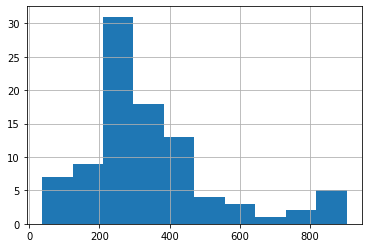

In [116]:
y_target.hist()

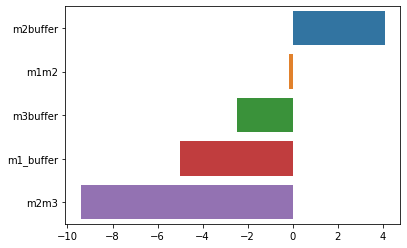

In [117]:
coef=pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values,y=coef_sort.index)

In [119]:
corr = df_5.corr(method = 'pearson')
corr

,m1_buffer,m1m2,m2buffer,m2m3,m3buffer,CycleTime
m1_buffer,1.000000,0.128936,-0.455924,-0.277414,-0.474056,-0.114929
m1m2,0.128936,1.000000,-0.165140,0.108374,-0.152334,-0.006938
m2buffer,-0.455924,-0.165140,1.000000,0.056467,-0.064466,0.177557
m2m3,-0.277414,0.108374,0.056467,1.000000,0.071330,0.016135
m3buffer,-0.474056,-0.152334,-0.064466,0.071330,1.000000,-0.037406
CycleTime,-0.114929,-0.006938,0.177557,0.016135,-0.037406,1.000000


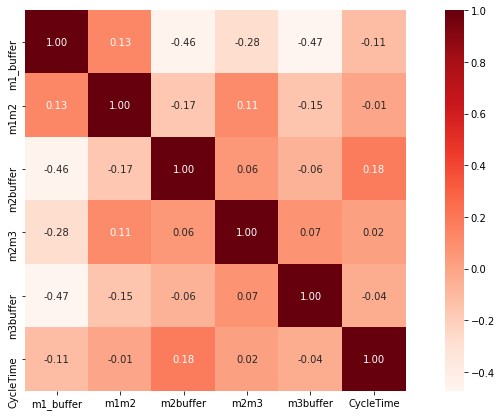

In [120]:
plt.subplots(figsize=(14,7))
df_heatmap = sns.heatmap(corr, cbar = True, annot = True, annot_kws={'size' : 10}, fmt = '.2f', square = True, cmap = 'Reds')

## LightGBM

In [121]:
import lightgbm as lgb

# LightGBM dataSet으로 변환
y_target = df_5['CycleTime']
X_features = df_5.drop(['CycleTime'],axis=1,inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

train_LightGBM = lgb.Dataset(X_train, label = y_train) 
test_LightGBM = lgb.Dataset(X_test, label = y_test) 

In [122]:
#파라미터 세팅
params = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2018}

In [123]:
#학습
model = lgb.train(params, train_LightGBM, 1000, test_LightGBM, verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 29580.7
Early stopping, best iteration is:
[81]	valid_0's l2: 29406.2


In [124]:
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

In [125]:
mse = mean_squared_error(y_test, predict_test)
r2 = r2_score(y_test, predict_test)

In [126]:
print('Mean squared error: ', mse)
print('R2 score: ', r2)

Mean squared error:  29424.424875649158
R2 score:  0.013772108873110644


In [127]:
final_result_LightGBM = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(predict_test)], axis = 1)
final_result_LightGBM.columns = ['label','predict']

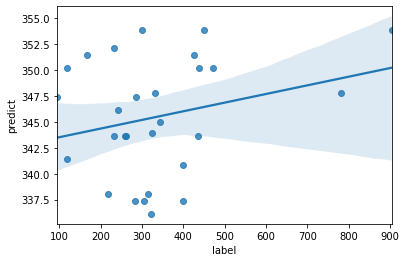

In [128]:
#fit 결과 확인
sns.regplot(x = 'label', y = 'predict', data = final_result_LightGBM)

## Ridge Regression

In [129]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

y_target = df_5['CycleTime']
X_features = df_5.drop(['CycleTime'],axis=1,inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
pred=ridge_reg.predict(X_test)

print("훈련 세트의 정확도 : {:.2f}".format(ridge_reg.score(X_train,y_train)))
print("테스트 세트의 정확도 : {:.2f}".format(ridge_reg.score(X_test,y_test)))
evaluate_regr(y_test,pred)

훈련 세트의 정확도 : 0.01
테스트 세트의 정확도 : 0.06
RMSLE: 0.5043291057, RMSE: 167.1345148383, MAE: 118.3171035551


## Lasso Regression

In [130]:
from sklearn.linear_model import Lasso

y_target = df_5['CycleTime']
X_features = df_5.drop(['CycleTime'],axis=1,inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)
pred=lasso_reg.predict(X_test)

print("훈련 세트의 정확도 : {:.2f}".format(lasso_reg.score(X_train, y_train)))
print("테스트 세트의 정확도 : {:.2f}".format(lasso_reg.score(X_test, y_test)))
print("사용한 특성의 수 : {}".format(np.sum(lasso_reg.coef_ != 0)))
print("사용한 max_iter : {}".format(lasso_reg.n_iter_))
evaluate_regr(y_test,pred)

훈련 세트의 정확도 : 0.01
테스트 세트의 정확도 : 0.06
사용한 특성의 수 : 4
사용한 max_iter : 8
RMSLE: 0.5041089873, RMSE: 167.2124454178, MAE: 118.0307459201


## Elastic Net

In [145]:
from sklearn.linear_model import ElasticNet

y_target = df_5['CycleTime']
X_features = df_5.drop(['CycleTime'],axis=1,inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=0)
elastic_net.fit(X_train, y_train)
pred=elastic_net.predict(X_test)

print("훈련 세트의 정확도 : {:.2f}".format(elastic_net.score(X_train, y_train)))
print("테스트 세트의 정확도 : {:.2f}".format(elastic_net.score(X_test, y_test)))
evaluate_regr(y_test,pred)

훈련 세트의 정확도 : 0.01
테스트 세트의 정확도 : 0.06
RMSLE: 0.5041355370, RMSE: 167.1170800825, MAE: 118.1817308124


In [146]:
pred

array([339.35589342, 354.27465185, 347.894696  , 314.01847305,
       315.56088191, 363.46729856, 357.79358148, 357.10286494,
       370.58037801, 357.01827636, 317.7774324 , 325.72199773,
       354.63439402, 347.25908425, 367.08093883, 370.06271007,
       332.6152539 , 336.77969182, 325.24556982, 368.08253765,
       341.8980181 , 348.94212799, 355.80590038, 320.80057813,
       396.26357901, 337.73452168, 313.43089405, 349.23654652])

## Decision Tree

In [143]:
from sklearn.tree import DecisionTreeRegressor

y_target = df_5['CycleTime']
X_features = df_5.drop(['CycleTime'],axis=1,inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

dt_reg = DecisionTreeRegressor(random_state = 0)
dt_reg.fit(X_train, y_train)
pred = dt_reg.predict(X_test)

evaluate_regr(y_test,pred)

RMSLE: 0.7233736383, RMSE: 296.0494649789, MAE: 225.5714285714


In [144]:
pred

array([845., 621., 473., 289., 462., 856., 377., 621., 251., 763., 247.,
       231., 266., 220., 459., 201., 231., 436., 289., 340., 220., 828.,
       639., 231., 255., 266., 417., 377.])

## Random Forest

In [140]:
from sklearn.ensemble import RandomForestRegressor

y_target = df_5['CycleTime']
X_features = df_5.drop(['CycleTime'],axis=1,inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

rf_reg = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=150)
rf_reg.fit(X_train, y_train)
pred = rf_reg.predict(X_test)

featureImportance = rf_reg.feature_importances_

evaluate_regr(y_test,pred)

RMSLE: 0.5431896619, RMSE: 183.4900864541, MAE: 131.4238150807


In [141]:
pred

array([365.20286976, 369.70748919, 429.89817209, 384.39982874,
       368.86452928, 348.49130787, 276.05202008, 434.14020723,
       352.08263266, 443.49238901, 379.89460833, 392.64720488,
       280.4149452 , 325.59290057, 427.65381156, 314.39913184,
       394.65770458, 324.08575575, 376.43687024, 313.50002933,
       341.90895324, 396.59334958, 452.82603564, 416.28362999,
       368.86602926, 324.07263827, 352.65914283, 288.04955469])

## SVR

In [134]:
from sklearn.svm import SVR

y_target = df_5['CycleTime']
X_features = df_5.drop(['CycleTime'],axis=1,inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

sv_reg = SVR(kernel = 'rbf')
sv_reg.fit(X_train, y_train)
pred = sv_reg.predict(X_test)
#pred = inverse_transform(y_pred)

evaluate_regr(y_test,pred)

RMSLE: 0.4942089041, RMSE: 179.6835141786, MAE: 117.1899113128


In [137]:
X_test.head()

,m1_buffer,m1m2,m2buffer,m2m3,m3buffer
17,10,0,3,1,1
45,6,1,4,2,1
71,4,2,0,0,8
31,13,3,0,1,0
28,14,2,0,0,1


In [139]:
pred

array([288.41051461, 289.01096195, 286.63210617, 287.74651726,
       287.70828839, 288.28850421, 286.65245438, 288.46943681,
       288.33687126, 288.45107726, 287.04927253, 288.1688182 ,
       286.89125055, 287.90450596, 288.33879603, 286.68955368,
       288.03483034, 288.09680333, 287.49502905, 287.54320446,
       287.83604279, 288.45062146, 288.06736172, 288.15194313,
       289.41597479, 287.77691933, 288.03886712, 286.53037916])

## 앙상블

## 딥러닝

In [168]:
#데이터를 불러옵니다.
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#train = pd.read_csv('train.csv')
#test = pd.read_csv('test.csv')


#독립변수와 종속변수를 분리합니다.
#train_X = train.iloc[:,4:]
#train_Y = train.iloc[:,0:4]
#test_X = test.iloc[:,1:]

y_target = df_5['CycleTime']
X_features = df_5.drop(['CycleTime'],axis=1,inplace=False)

X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

#케라스를 통해 모델 생성을 시작합니다.
import keras
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(units=160, activation='relu', input_dim=5))
model.add(Dense(units=160, activation='relu'))
model.add(Dense(units=160, activation='relu'))
model.add(Dense(units=1, activation='linear'))

#모델을 컴파일합니다.
model.compile(loss='mae', optimizer='adam', metrics=['mae'])

#모델을 학습합니다.
model.fit(X_train, y_train, epochs=200, batch_size=10000, validation_split = 0.05)

#예측값을 생성합니다.
pred_test = model.predict(X_test)

#submission 파일을 생성합니다.
#sample_sub = pd.read_csv('sample_submission.csv', index_col=0)
#submission = sample_sub+pred_test
#submission.to_csv('submission.csv')

Epoch 1/200
1/1 [==============================] - 1s 671ms/step - loss: 339.6046 - mae: 339.6046 - val_loss: 407.1815 - val_mae: 407.1815
Epoch 2/200
1/1 [==============================] - 0s 46ms/step - loss: 339.0316 - mae: 339.0316 - val_loss: 406.7948 - val_mae: 406.7948
Epoch 3/200
1/1 [==============================] - 0s 41ms/step - loss: 338.4796 - mae: 338.4796 - val_loss: 406.3648 - val_mae: 406.3648
Epoch 4/200
1/1 [==============================] - 0s 39ms/step - loss: 337.9120 - mae: 337.9120 - val_loss: 405.8785 - val_mae: 405.8785
Epoch 5/200
1/1 [==============================] - 0s 43ms/step - loss: 337.2913 - mae: 337.2913 - val_loss: 405.3270 - val_mae: 405.3270
Epoch 6/200
1/1 [==============================] - 0s 38ms/step - loss: 336.5958 - mae: 336.5958 - val_loss: 404.7052 - val_mae: 404.7052
Epoch 7/200
1/1 [==============================] - 0s 38ms/step - loss: 335.8053 - mae: 335.8053 - val_loss: 404.0070 - val_mae: 404.0070
Epoch 8/200
1/1 [================

In [170]:
y_test = np.reshape(y_test.to_numpy(), (-1, 1))
evaluate_regr(y_test,pred_test)

RMSLE: 0.5156601586, RMSE: 185.8904515474, MAE: 118.9861243112


In [171]:
pred_test

array([[296.2271 ],
       [266.44043],
       [273.7624 ],
       [284.80182],
       [293.44446],
       [212.87964],
       [219.10745],
       [295.4959 ],
       [170.47511],
       [323.72968],
       [296.19537],
       [289.4347 ],
       [259.1271 ],
       [268.64743],
       [291.84744],
       [258.84808],
       [255.07095],
       [260.46146],
       [289.12143],
       [359.18008],
       [286.74918],
       [249.42175],
       [228.72844],
       [306.1446 ],
       [279.90347],
       [330.17126],
       [342.69308],
       [266.6174 ]], dtype=float32)

In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.optimizers import Adam

In [175]:
from keras.layers import Activation, Dropout, BatchNormalization, Input
from keras.layers import *

y_target = df_5['CycleTime']
X_features = df_5.drop(['CycleTime'],axis=1,inplace=False)

X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

In [187]:
model = Sequential()
model.add(Dense(units=768, activation='relu', input_dim=5))
model.add(Dropout(0.1))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1, activation='relu'))

In [192]:
model.compile(loss='mae', optimizer='adam', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=100, batch_size=10000, validation_split = 0.05)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 87.4229 - mae: 87.4229 - val_loss: 257.5831 - val_mae: 257.5831
Epoch 2/100
1/1 [==============================] - 0s 47ms/step - loss: 244.5160 - mae: 244.5160 - val_loss: 198.0572 - val_mae: 198.0572
Epoch 3/100
1/1 [==============================] - 0s 49ms/step - loss: 193.9860 - mae: 193.9860 - val_loss: 237.5402 - val_mae: 237.5402
Epoch 4/100
1/1 [==============================] - 0s 46ms/step - loss: 136.5551 - mae: 136.5551 - val_loss: 260.8007 - val_mae: 260.8007
Epoch 5/100
1/1 [==============================] - 0s 48ms/step - loss: 156.3794 - mae: 156.3794 - val_loss: 158.8375 - val_mae: 158.8375
Epoch 6/100
1/1 [==============================] - 0s 56ms/step - loss: 115.9183 - mae: 115.9183 - val_loss: 147.2184 - val_mae: 147.2184
Epoch 7/100
1/1 [==============================] - 0s 46ms/step - loss: 138.3858 - mae: 138.3858 - val_loss: 136.7678 - val_mae: 136.7678
Epoch 8/100
1/1 [=====================

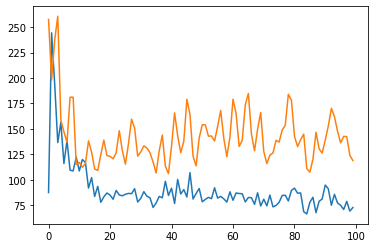

In [193]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [194]:
pred_test = model.predict(X_test)

#sample_sub = pd.read_csv('sample_submission.csv', index_col=0)
#submission = sample_sub+pred_test
#submission.to_csv('baseline_추가.csv')

In [196]:
#y_test = np.reshape(y_test.to_numpy(), (-1, 1))
evaluate_regr(y_test,pred_test)

RMSLE: 0.6374760948, RMSE: 243.4801514679, MAE: 155.4012222290
